# Final project

In [3]:
# Import the necessary package
import csv
import copy
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
%matplotlib inline

In [4]:
#导入数据并进行特征选择
# Import the data and choose the features that relate to the topic
# Document: kc_house_data
df = pd.read_csv('Original Data/house_data.csv')
# Document: melb_data
#df = pandas.read_csv('Original Data/melb_data.csv')

# Document: kc_house_data
feature_list = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors',
              'view','condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long']]
# Document: melb_data
#feature_list = df[['Rooms','Bedroom2','Bathroom','Distance','Landsize','BuildingArea','YearBuilt', 'Car', 'Lattitude', 'Longtitude']]
feature_list.fillna(feature_list.mean(), inplace=True)

# Document: kc_house_data
price = df[['price']]
# Document: melb_data
#price = df[['Price']]
price.fillna(price.mean(), inplace=True)

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
#本次项目主要分为以下几个部分：
# (1)数据分析可视化部分
# (2)数据预处理部分
# (3)模型训练和预测
# (4)结果分析
# (5)总结

# Project include the following parts:
# (1)Data Visualization (Analyse the most significant features which affect the house price.)
# (2)Data Preprocession (Preproecss the data and remove the extreme lines)
# (3)Model selection(5), training, and prediction 
# (4)Cost Performance Evalution
# (5)Summary

In [6]:
# 1.数据分析可视化部分
# 1.Data Visualization

In [7]:
df.head()

features = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 
            'condition', 'grade', 'sqft_above', 'sqft_basement']
num_of_features = len(features)
x = df[features].values
y = df['price'].values

In [8]:
# 查看相关数据
# Check some basic information of data

min_price = np.min(price)
max_price = np.max(price)
mean_price = np.mean(price)
median_price = np.median(price)
std_price = np.std(price)
print (f"Statistics for Boston housing dataset:")
print ("min_price:    %.2f" % min_price)
print ("max_price:    %.2f" % max_price)
print ("mean_price:   %.2f" % mean_price)
print ("median_price: %.2f" % median_price)
print ("std_price:    %.2f" % std_price)

Statistics for Boston housing dataset:
min_price:    75000.00
max_price:    7700000.00
mean_price:   540088.14
median_price: 450000.00
std_price:    367118.70


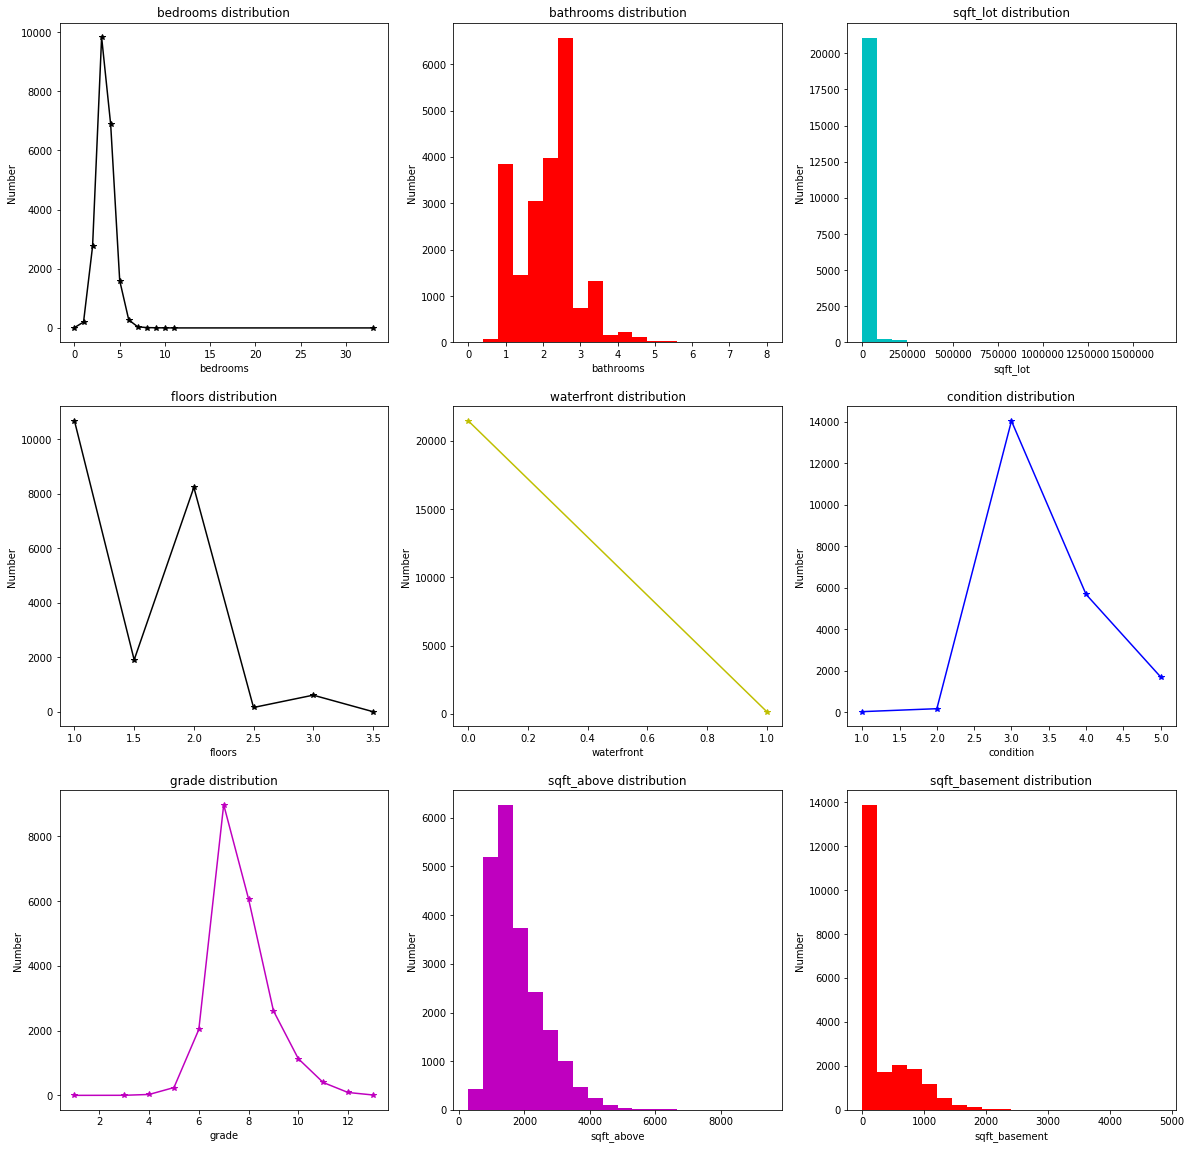

In [9]:
# Data Distribution Map

import random
plt.figure(figsize=(20, 20))
colors = ['blue', 'r', 'c', 'm', 'y', 'k']
for i in range(num_of_features):
    plt.subplot(3, 3, i+1)
    
    color = random.choice(colors)
    feature = features[i]
    values = df[feature].values
    unique, counts = np.unique(values, return_counts=True)
    
    if (len(counts) <= 20):
        plt.plot(unique, counts, color, marker='*')
        plt.xlabel(feature)
        plt.ylabel('Number')
        plt.title('%s distribution' % feature)
    
    else:
        plt.hist(df[feature].values, bins=20, color=color)
        plt.xlabel(feature)
        plt.ylabel('Number')
        plt.title('%s distribution' % feature)

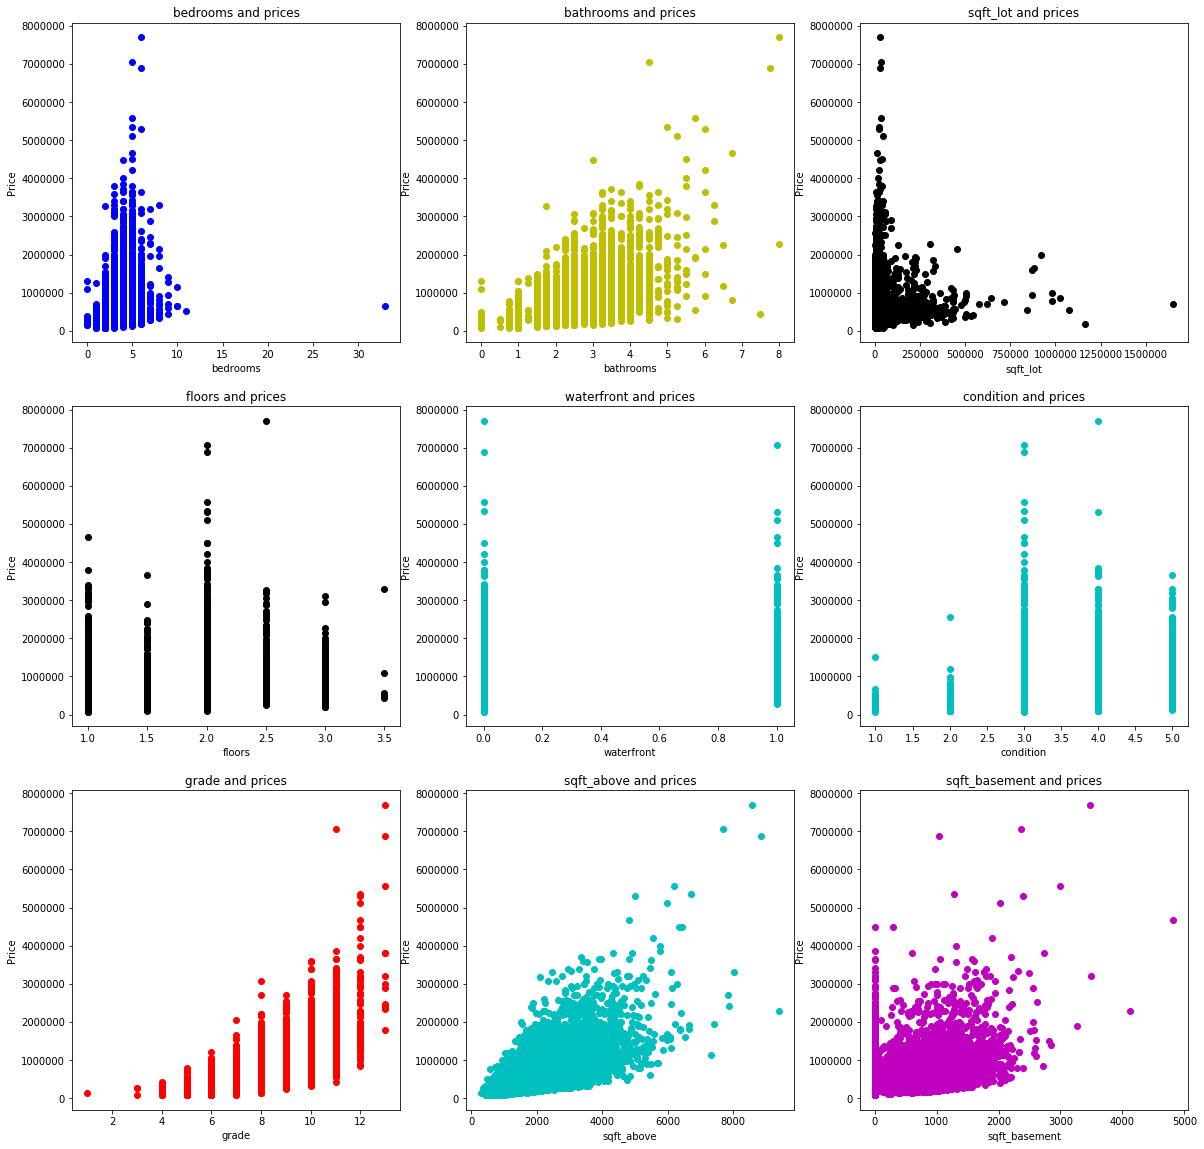

In [10]:
# Data Scatter Plot

plt.figure(figsize=(20, 20))
y_mean = np.mean(y)
for i in range(num_of_features):
    color = random.choice(colors)
    feature = features[i]
    values = df[feature].values
    
    plt.subplot(3, 3, i+1)
    plt.scatter(values, y, color=color)
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title('%s and prices' % feature)

price            1.000000
grade            0.667434
sqft_above       0.605567
bathrooms        0.525138
sqft_basement    0.323816
bedrooms         0.308350
waterfront       0.266369
floors           0.256794
sqft_lot         0.089661
condition        0.036362
Name: price, dtype: float64


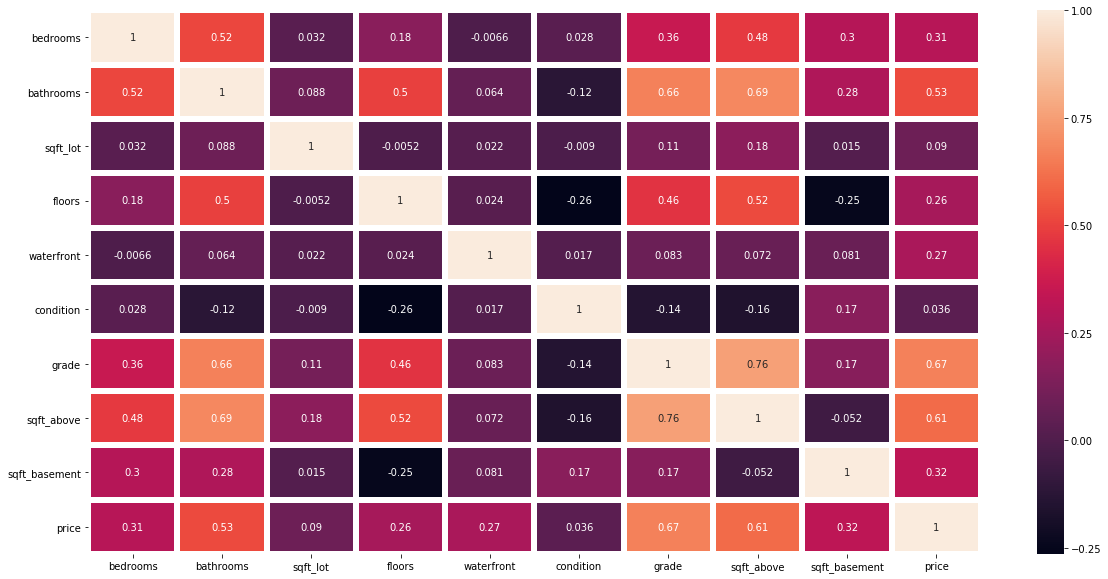

In [11]:
# Data Thermal Diagram

import seaborn as sns
import copy
plt.figure(figsize=(20,10))
if 'price' not in features:
    features.append('price')
corrmat = df[features].corr()
print(corrmat['price'].sort_values(ascending=False))
sns.heatmap(corrmat, square=False, linewidth=5, annot=True)

In [12]:
# 2.数据预处理部分
# 2.Data Preprocession

In [13]:
def detect_outliers(df,n,features):

    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
        outlier_indices.extend(outlier_list_col)
        x = np.array(outlier_list_col)
        #print(len(x))
    return outlier_list_col
Outliers_to_drop = detect_outliers(df, 2, ['price'])
print("The outliers detected before drop: ", len(Outliers_to_drop))
df = df.drop(Outliers_to_drop, axis=0).reset_index(drop=True)
Outliers_to_drop = detect_outliers(df, 2, ['price'])
print("The outliers detected after drop:  ", len(Outliers_to_drop))

The outliers detected before drop:  1146
The outliers detected after drop:   264


In [14]:
# 3.模型训练和预测
# 3.Model selection(5), training, and prediction 

# In this project, we use each of following method to instantiate the model object
# After that, use the model to predict yhat and KFold to instantiate cross validation object. 
# Finally, we choose cross_val_score method for cross validation. 
# We judge the fitness of the model by calculating the value of R2. 
# Usually, the closer the value is to 1, the better the effect.


# 使用随机森林回归模型做回归预测，并使用交叉验证查看模型得分。
# 调用sklearn.tree库的xxx法实例化模型对象。
# 调用sklearn.model_selection库的KFold方法实例化交叉验证对象。
# 调用sklearn.model_selection库的cross_val_score方法做交叉验证。

In [15]:
# Get the value of X and y by the original data and related features
X = np.array(feature_list)
y = np.array(price)

# Split X, y to X_train, X_test, y_train, y_test according to cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, shuffle=True)

The first model is linear regression model. Linear regression can describe the relationship between data accurately with a straight line. In this way, when new data emerges, a simple value can be predicted. Linear regression is often used in house price forecasting. Linear Regression have a fast Modeling speed, it does not need very complicated calculation. Also, Each variables can be understand and explained according to the coefficients. Besides these, It is sensitive to outliers.

In [16]:
# 模型一：线性回归模型
# Module 1: LinearRegression

LinearRegression_model = LinearRegression()
LinearRegression_model.fit(X_train, y_train)

yhat = LinearRegression_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
#print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(LinearRegression_model, X_test, y_test.ravel(), cv=kf)

print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

r2_score =  [0.7055052  0.69411207 0.69840903 0.6643802  0.70082137]
r2_score_average =  0.6926455728758205


The second model is decision tree regression model. Decision tree is a common non-parametric supervised learning method for classification and regression. The goal is to create a model to predict the value of target variables by deducing simple decision rules from data characteristics. It is a module that simple and easy to understand, and the number structure can be visualized. Also, It can deal with multi-output problem.

In [17]:
# 模型二：决策树回归模型
# Module 2: DecisionTreeRegressor

DecisionTree_model = DecisionTreeRegressor()
DecisionTree_model.fit(X_train, y_train)

yhat = DecisionTree_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
#print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(DecisionTree_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

r2_score =  [0.6551927  0.72314129 0.52401893 0.7383957  0.63544572]
r2_score_average =  0.6552388669890825


Beside above two module, we also use three integration regression from ensemble module in sklearn: Random Forest Regressor, Extra Trees Regressor and Gradient Boosting Regressor.
For Random Forest Regressor, it is a random forest regressor, and fits a number of classifying decision trees on various sub-subsample of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. This regressor will randomly choose features to predict, which will probably be a potential problem. It have a fast training spped of random forest algorithm, and random forest algorithms acan be applied to many type of model tasks.

In [18]:
# 模型三：随机森林回归模型
# Module 3: RandomForestRegressor

randomForest_model = RandomForestRegressor()
randomForest_model.fit(X_train, y_train)

yhat = randomForest_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
#print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(randomForest_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


r2_score =  [0.82237203 0.82552311 0.80115278 0.84690462 0.84212683]
r2_score_average =  0.8276158740173098


We also use ExtraTreesRegressor module to predict the result. 
ExtraTreeRegressor module is an extra-trees regressor, and this class implements a meta estimator that fits a number of randomized decision trees on various sub-samples of dataset. This estimator wouldn't pick features randomly, it will randonly collect part of feature and then use entropy information to find the best/most important sum-sample features.

Use the ExtraTreesRegressor method to instantiate the model object. Then, use the model to predict yhat and use KFold method to instantiate cross validation object. Finally, use the cross_val_score method for cross validation. We judge the fitness of the model by calculating the value of R2. Usually, the closer the value is to 1, the better the effect.

In [19]:
# 模型四：极限🌲回归模型
# Module 4: ExtraTreesRegressor

ExtraTrees_model = ExtraTreesRegressor()
ExtraTrees_model.fit(X_train, y_train)

yhat = ExtraTrees_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
#print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(ExtraTrees_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


r2_score =  [0.87394251 0.81826358 0.82655572 0.82016468 0.8033044 ]
r2_score_average =  0.8284461786400282


Use the GradientBoostingRegressor method to instantiate the model object. Then, use the model to predict yhat and use KFold method to instantiate cross validation object. Finally, use the cross_val_score method for cross validation. We judge the fitness of the model by calculating the value of R2. Usually, the closer the value is to 1, the better the effect.

In [20]:
#模型五：梯度增强回归模型
# Module 5: GradientBoostingRegressor

GradientBoostingRegressor_model = GradientBoostingRegressor(n_estimators = 400, min_samples_split = 2,
         learning_rate = 0.1, loss = 'ls')
GradientBoostingRegressor_model.fit(X_train, y_train)

yhat = GradientBoostingRegressor_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(GradientBoostingRegressor_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())


/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2_score =  [0.88997382 0.89133282 0.8603085  0.83906742 0.86322103]
r2_score_average =  0.8687807192995685


In [21]:
# 4.性价比分析
# 4.Cost Performance Evaluation

In [22]:
def CP(x,yts):
    yhat = GradientBoostingRegressor_model.predict(x)
    m = (yts - yhat)/yts
    if(((yts - yhat)/yts)>=0.05):
        print(f'it has a good cost performance,which is  {np.round(m*100,2)} %' )
    if(((yts - yhat)/yts)<0.05 and (yts - yhat)>0 ):
        print(f'it has a normal cost performance,which is {np.round(m*100,2)}% cheaper than expect' )
    if(((yts - yhat)/yts)<-0.05 and ((yts - yhat)/yts)>-0.1 ):
         print(f'it is cost performance is less than satisfactory, which is  {np.round(m*100,2)}%  expensive than expect' )
    if(((yts - yhat)/yts)<-0.1 ):
        print(f'it is hard bargain, which is {np.round(m*100,2)}%  expensive than expect' )
CP( [[4,  2,  1.78000e+03,  7.35000e+03,  1.00000e+00,
  0.00000e+00,  5.00000e+00,  7.00000e+00,  9.00000e+02,  8.80000e+02,
   1.97400e+03,  4.74562e+01, -1.22158e+02]],280000)

it is cost performance is less than satisfactory, which is  [-8.73]%  expensive than expect


In [23]:
# Reconstruct the model with selected features,since we know the relation between features and price

feature_list1 = df[['bedrooms','bathrooms','sqft_living','floors',
              'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long']]
X_new = np.array(feature_list)
y_new = np.array(price)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.30, train_size=0.70, shuffle=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.30, train_size=0.70, shuffle=True)
GradientBoostingRegressor_model = GradientBoostingRegressor(n_estimators = 400, min_samples_split = 2,
         learning_rate = 0.1, loss = 'ls')
GradientBoostingRegressor_model.fit(X_train, y_train)

yhat = GradientBoostingRegressor_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(GradientBoostingRegressor_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())
print(X_train.shape[0])
# we can see that the final r2_score is not higher than before, so we can learn that the more related fetures we use, the more
# accurate the final r2_score is, though it may cost more time to calculate 

(15129, 13) (6484, 13) (15129, 1) (6484, 1)


/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2_score =  [0.88685257 0.8362339  0.84020746 0.84395085 0.87596487]
r2_score_average =  0.8566419311519997
15129


In [ ]:
# 5.总结
# 5.Summary